In [9]:
from itertools import product
import os
import pandas as pd
import seaborn as sns

def get_names(sam_file, unique=False):
    f = open(sam_file, 'r')
    all_names = []
    non_unique_names = []
    for line in f:
        if line != "" and line[0]!="@":#line[0].isalpha():
            name = line.split('\t')[0]
            if unique and name in all_names:
                non_unique_names.append(name)
                print(name, [i for i in all_names if i==name])
            else:
                all_names.append(name)
    print("all names", len(all_names))
    print("non unique names", len(non_unique_names))
    f.close()
    return(all_names, non_unique_names)

def parse_sam(sam_file, unique=False):
    all_names, non_unique_names = get_names(sam_file, unique)
    
    num_cluster_tp = 0
    num_cluster_fp = 0
    num_gene_tp = 0
    num_gene_fp = 0
    num_non_unique_entries = 0
    
    f = open(sam_file, 'r')
    for line in f:
        if line == "" or not line[0].isalpha():
            continue
        elif line.split('\t')[0] in non_unique_names:
            num_non_unique_entries += 1
            continue
        elif line.split('\t')[1]=="0" or line.split('\t')[1]=="16":
            if line.startswith("Cluster"):
                num_cluster_tp += 1
            else:
                num_gene_tp += 1
        else:
            if line.startswith("Cluster"):
                num_cluster_fp += 1
            else:
                num_gene_fp += 1
    f.close()
    return num_cluster_tp, num_cluster_fp, num_gene_tp, num_gene_fp, num_non_unique_entries 

def generate_summary():
    ws = [6,10,14,18,22,26]
    ks = [11,15,19,23,27,31,35]
    covgs = [15,30,60,100]
    min_cluster_sizes = [5,10,15]
    max_cluster_distances = [20,30,40,80,160,250,320]
    df = pd.DataFrame(columns=['w','k','covg','min_cluster_size','max_cluster_distance',
                               'num_cluster_tp','num_cluster_fp','num_gene_tp',
                               'num_gene_fp','num_non_unique_entries'])
    
    for w,k,covg,min_cluster_size,max_cluster_distance in product(ws,ks,covgs,min_cluster_sizes,
                                                                  max_cluster_distances):
        f = "/hps/nobackup/research/zi/rmcolq/paper_4_way/FP_gene_evaluation/benchmark/%d/%d/%d/%d/%d/summary.sam" %(w,k,covg,min_cluster_size,max_cluster_distance)
        if os.path.exists(f):
            num_cluster_tp, num_cluster_fp, num_gene_tp, num_gene_fp, num_non_unique_entries = parse_sam(f)
            new_row = {'w':w, 'k':k, 'covg':covg, 'min_cluster_size':min_cluster_size, 
                       'max_cluster_distance':max_cluster_distance, 'num_cluster_tp':num_cluster_tp,
                       'num_cluster_fp':num_cluster_fp,'num_gene_tp':num_gene_tp,
                       'num_gene_fp':num_gene_fp,'num_non_unique_entries':num_non_unique_entries}
            df = df.append(new_row, ignore_index=True)
    return df

#df = generate_summary()
#df.to_csv("all_summary.csv")

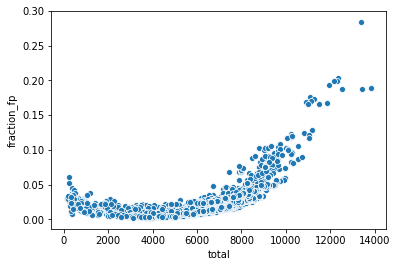

In [34]:
df = pd.read_csv("all_summary.csv", index_col=0)

df['total_tp'] = df['num_cluster_tp'] + df['num_gene_tp']
df['total_fp'] = df['num_cluster_fp'] + df['num_gene_fp']
df['total'] = df['total_tp'] + df['total_fp']
df['fraction_fp'] = df['total_fp'] / df['total']

sns.scatterplot(x="total", y="fraction_fp", data=df)

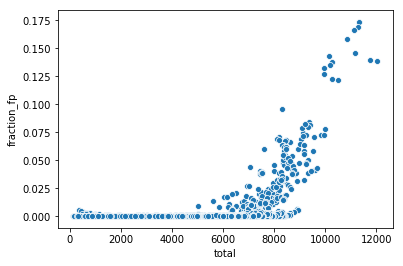

In [37]:
df = pd.read_csv("all_unique_summary.csv", index_col=0)

df['total_tp'] = df['num_cluster_tp'] + df['num_gene_tp']
df['total_fp'] = df['num_cluster_fp'] + df['num_gene_fp']
df['total'] = df['total_tp'] + df['total_fp']
df['fraction_fp'] = df['total_fp'] / df['total']

sns.scatterplot(x="total", y="fraction_fp", data=df)

In [38]:
df = df[df["fraction_fp"] < 0.05]
df = df[df["total"] > 6000]

In [63]:
default = df
default = default[default["w"] == 14]
default = default[default["k"] == 15]
default = default[default["min_cluster_size"] == 10]
default = default[default["max_cluster_distance"] == 250]

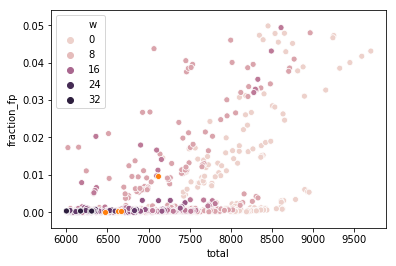

In [64]:
sns.scatterplot(x="total", y="fraction_fp", data=df, hue="w")
default_w = df[df["w"] == 14]
#sns.scatterplot(x="total", y="fraction_fp", data=default_w)
sns.scatterplot(x="total", y="fraction_fp", data=default)
# higher w reduces fp and number found

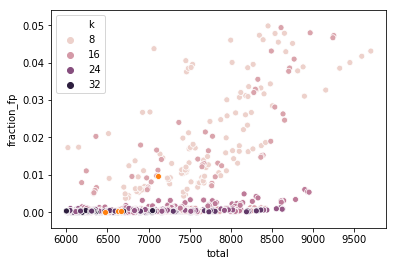

In [65]:
sns.scatterplot(x="total", y="fraction_fp", data=df, hue="k")
default_k = df[df["k"] == 15]
#sns.scatterplot(x="total", y="fraction_fp", data=default_k)
sns.scatterplot(x="total", y="fraction_fp", data=default)
# higher k reduces fp, and total number found

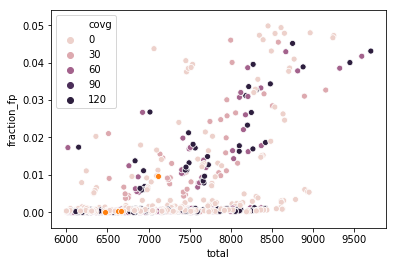

In [56]:
sns.scatterplot(x="total", y="fraction_fp", data=df, hue="covg")
sns.scatterplot(x="total", y="fraction_fp", data=default)
# little coverage difference 

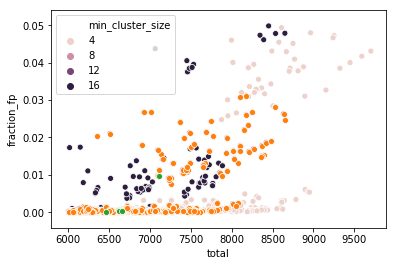

In [61]:
sns.scatterplot(x="total", y="fraction_fp", data=df, hue="min_cluster_size")
default_x = df[df["min_cluster_size"] == 10]
sns.scatterplot(x="total", y="fraction_fp", data=default_x)
sns.scatterplot(x="total", y="fraction_fp", data=default)
# default parameter 10, possibly higher better

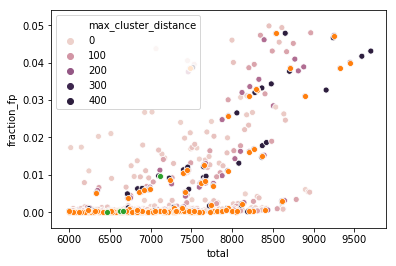

In [62]:
sns.scatterplot(x="total", y="fraction_fp", data=df, hue="max_cluster_distance")
default_x = df[df["max_cluster_distance"] == 250]
sns.scatterplot(x="total", y="fraction_fp", data=default_x)
sns.scatterplot(x="total", y="fraction_fp", data=default)
# makes no difference, leave at default parameter 250